In [1]:
import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt

import pytorch_lightning as pl


random_seed = 42
torch.manual_seed(random_seed)

BATCH_SIZE=128
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS=int(os.cpu_count() / 2)

/home/dennis00/anaconda3/envs/scRNA-GAN-TF/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [1]:

import scanpy as sc
import matplotlib.pyplot as plt
import scrublet as scr
import numpy as np
import h5py
from scipy.sparse import csc_matrix
import decoupler as dc
import pandas as pd
import anndata as ad


In [2]:

scRNA_Seq = sc.read_h5ad("../ZafrensData/zel024/rnaseq/4073_4074_final.h5ad")


## UMAP visualization

In [10]:

adata = scRNA_Seq

# Assuming adata is your AnnData object
# Step 1: Normalize and preprocess your data if not already done
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var.highly_variable]

# Step 2: Scale and reduce dimensionality
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata)

# Step 3: Compute neighbors and UMAP
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata)


/home/dennis00/anaconda3/envs/scRNA-GAN-TF/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [25]:
adata.var_names

Index(['AL627309.2', 'SAMD11', 'TTLL10', 'AURKAIP1', 'ATAD3B', 'AL590822.2',
       'RER1', 'AL592464.3', 'LINC02780', 'Z98886.1',
       ...
       'MT-CO2', 'MT-ATP8', 'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4',
       'MT-ND5', 'MT-ND6', 'MT-CYB'],
      dtype='object', length=2000)

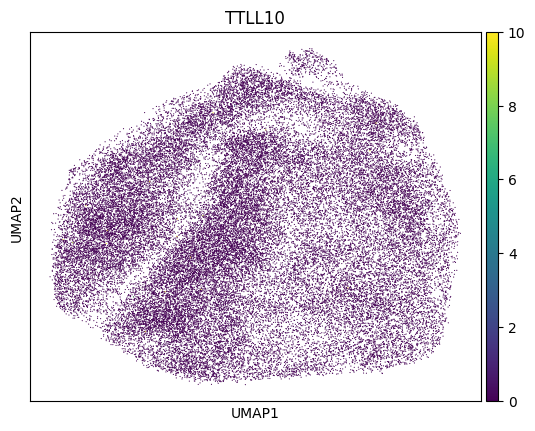

In [26]:
# Visualize UMAP embedding
sc.pl.umap(adata, color=['TTLL10'])


In [3]:

# Subset the AnnData object based on the 'censored' column
subset_scRNA_Seq = scRNA_Seq[scRNA_Seq.obs['censored'] == False].copy()

# Check the subset to confirm the changes
print(subset_scRNA_Seq)


AnnData object with n_obs × n_vars = 35737 × 29084
    obs: 'device_id', 'control_rx_id', 'bb1_id', 'bb2_id', 'bb3_id', 'bb4_id', 'censored', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'sample', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'


In [4]:
subset_scRNA_Seq.obs

,device_id,control_rx_id,bb1_id,bb2_id,bb3_id,bb4_id,censored,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,...,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo,total_counts_hb,log1p_total_counts_hb,pct_counts_hb,n_genes,sample,doublet_score,predicted_doublet
2,4073,-1,213,123,2,1943,False,3138,8.051660,5807.0,...,1313.0,7.180831,22.610641,1.0,0.693147,0.017221,3138,4073_-1_213_123_2_1943_False,0.149171,False
3,4073,-1,202,422,2,1943,False,1278,7.153834,2102.0,...,492.0,6.200509,23.406279,0.0,0.000000,0.000000,1278,4073_-1_202_422_2_1943_False,0.081709,False
4,4073,-1,201,422,1,1943,False,2718,7.908019,4526.0,...,765.0,6.641182,16.902342,1.0,0.693147,0.022095,2718,4073_-1_201_422_1_1943_False,0.026415,False
9,4073,-1,207,418,2,1943,False,777,6.656727,1429.0,...,491.0,6.198479,34.359695,0.0,0.000000,0.000000,777,4073_-1_207_418_2_1943_False,0.034388,False
10,4073,-1,215,417,1,1943,False,419,6.040255,1034.0,...,505.0,6.226537,48.839458,1.0,0.693147,0.096712,419,4073_-1_215_417_1_1943_False,0.119411,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55280,4074,-1,201,420,2,1559,False,2554,7.845808,3896.0,...,556.0,6.322565,14.271048,1.0,0.693147,0.025667,2554,4074_-1_201_420_2_1559_False,0.077854,False
55286,4074,-1,201,420,1,1559,False,2360,7.766841,3481.0,...,589.0,6.380123,16.920425,1.0,0.693147,0.028727,2360,4074_-1_201_420_1_1559_False,0.131313,False
55290,4074,-1,201,417,2,1559,False,598,6.395262,953.0,...,291.0,5.676754,30.535152,0.0,0.000000,0.000000,598,4074_-1_201_417_2_1559_False,0.080725,False
55292,4074,-1,213,422,1,1559,False,879,6.779922,1447.0,...,345.0,5.846439,23.842434,0.0,0.000000,0.000000,879,4074_-1_213_422_1_1559_False,0.084746,False


In [5]:

subset_scRNA_Seq.layers['counts'] = subset_scRNA_Seq.X.copy()

# Extract raw counts and sample info
counts = subset_scRNA_Seq.layers['counts'].toarray()  # Or use .X if counts are stored there
sample_info = subset_scRNA_Seq.obs['sample']

# Create a DataFrame for aggregation
counts_df = pd.DataFrame(counts, index=subset_scRNA_Seq.obs.index, columns=subset_scRNA_Seq.var_names)
counts_df['sample'] = sample_info

# Perform pseudobulk aggregation
pseudobulk_counts = counts_df.groupby('sample').sum()

# Convert back to AnnData if needed

pseudobulk_adata = ad.AnnData(
    X=pseudobulk_counts.values,
    obs=pd.DataFrame({'sample': pseudobulk_counts.index}, index=pseudobulk_counts.index)
)

pseudobulk_adata.obs = pseudobulk_adata.obs.rename_axis(None)
merged_df = pd.merge(pseudobulk_adata.obs, subset_scRNA_Seq.obs, on='sample', how='left')
merged_df.drop_duplicates(subset='sample', inplace=True)
merged_df.reset_index(inplace=True)
pseudobulk_adata.obs = merged_df
pseudobulk_adata.obs


/tmp/ipykernel_26298/2645034952.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pseudobulk_counts = counts_df.groupby('sample').sum()


In [25]:

pseudobulk_adata.write_h5ad("../ZafrensData/zel024/rnaseq/4073_4074_pseudobulk.h5ad")


# GAN code

In [2]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./data", 
                 batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

In [3]:
# Generate Fake Data: output like real data [1, 28, 28] and values -1, 1
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 7*7*64)  # [n, 256, 7, 7]
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2) # [n, 64, 16, 16]
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2) # [n, 16, 34, 34]
        self.conv = nn.Conv2d(16, 1, kernel_size=7)  # [n, 1, 28, 28]
    

    def forward(self, x):
        # Pass latent space input into linear layer and reshape
        x = self.lin1(x)
        x = F.relu(x)
        x = x.view(-1, 64, 7, 7)  #256
        
        # Upsample (transposed conv) 16x16 (64 feature maps)
        x = self.ct1(x)
        x = F.relu(x)
        
        # Upsample to 34x34 (16 feature maps)
        x = self.ct2(x)
        x = F.relu(x)
        
        # Convolution to 28x28 (1 feature map)
        return self.conv(x)

In [4]:
# Detective: fake or no fake -> 1 output [0, 1]
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # Simple CNN
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)
  
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Flatten the tensor so it can be fed into the FC layers
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)

In [9]:
class GAN(pl.LightningModule):
    def __init__(self, latent_dim=100, lr = 0.0002):
        super().__init__()
        self.save_hyperparameters()

        self.automatic_optimization = False

        self.generator = Generator(latent_dim=self.hparams.latent_dim)
        self.discriminator = Discriminator()

        self.validation_z = torch.randn(6, self.hparams.latent_dim)

    def forward(self, z):
        return self.generator(z)

    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)

    def training_step(self, batch, batch_idx):
    # Access optimizers manually
        opt_g, opt_d = self.optimizers()
    
        real_imgs, _ = batch
    
        # Generate noise and sample fake images
        z = torch.randn(real_imgs.size(0), self.hparams.latent_dim).type_as(real_imgs)
        fake_imgs = self(z)
    
        # -------- Train Generator --------
        # Maximize log(D(G(z)))
        self.toggle_optimizer(opt_g)  # Optional to prevent gradient accumulation from other optimizers
        y_hat = self.discriminator(fake_imgs)
        y = torch.ones(real_imgs.size(0), 1).type_as(real_imgs)
    
        g_loss = self.adversarial_loss(y_hat, y)
        opt_g.zero_grad()
        self.manual_backward(g_loss)
        opt_g.step()
        self.untoggle_optimizer(opt_g)
    
        self.log("g_loss", g_loss, prog_bar=True)
    
        # -------- Train Discriminator --------
        # Maximize log(D(x)) + log(1 - D(G(z)))
        self.toggle_optimizer(opt_d)
        y_hat_real = self.discriminator(real_imgs)
        y_real = torch.ones(real_imgs.size(0), 1).type_as(real_imgs)
        real_loss = self.adversarial_loss(y_hat_real, y_real)
    
        y_hat_fake = self.discriminator(fake_imgs.detach())
        y_fake = torch.zeros(real_imgs.size(0), 1).type_as(real_imgs)
        fake_loss = self.adversarial_loss(y_hat_fake, y_fake)
    
        d_loss = (real_loss + fake_loss) / 2
        opt_d.zero_grad()
        self.manual_backward(d_loss)
        opt_d.step()
        self.untoggle_optimizer(opt_d)
    
        self.log("d_loss", d_loss, prog_bar=True)


    def configure_optimizers(self):
        lr = self.hparams.lr
        opt_g = torch.optim.Adam(self.generator.parameters(), lr = lr)
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr = lr)
        return [opt_g, opt_d], []

    def plot_imgs(self):
        z = self.validation_z.type_as(self.generator.lin1.weight)
        sample_imgs = self(z).cpu()

        print('epoch', self.current_epoch)
        fig = plt.figure()
        for i in range(sample_imgs.size(0)):
            plt.subplot(2, 3, i + 1)
            plt.tight_layout()
            plt.imshow(sample_imgs.detach()[i, 0, :, :], cmap = 'gray_r', interpolation = 'none')
            plt.title("Generated Data")
            plt.xticks()
            plt.yticks()
            plt.axis('off')
        plt.show()
            
    def on_epoch_end(self):
        self.plot_imgs()
        

        

In [10]:
dm = MNISTDataModule()
model = GAN()

epoch 0


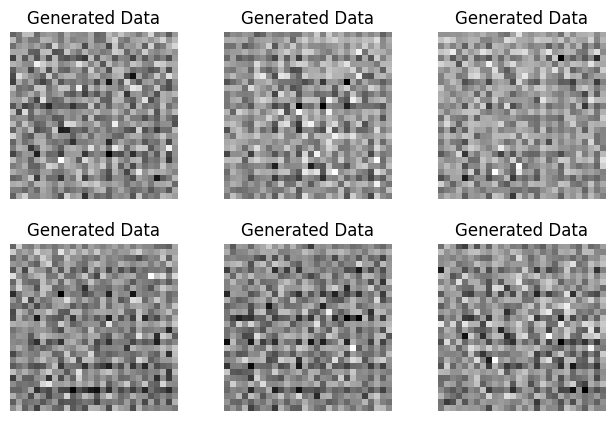

In [11]:
model.plot_imgs()

In [ ]:
trainer = pl.Trainer(max_epochs=20, accelerator="auto")
trainer.fit(model, dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | generator     | Generator     | 358 K  | train
1 | discriminator | Discriminator | 21.4 K | train
--------------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.520     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Training: |                                                                                       | 0/? [00:00…